### CNN per previsione multistep di dati univariati

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from math import sqrt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
from keras import metrics

data = pd.read_csv('/Users/alket/desktop/dati/new_data_backfill_forwfill.csv',index_col = 0)

agg_by_cell = data.groupby(by = ['cell_num'])
one_cell = agg_by_cell.get_group('486-1252')
series = one_cell['nr_people'].values
print(type(series))

<class 'numpy.ndarray'>


### Crea finestra di lag

In [14]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# choose a number of time steps
n_steps_in, n_steps_out = 96, 25

# split into samples
X, y = split_sequence(series, n_steps_in, n_steps_out)

count = 0
for i in range(len(X)):
    print(X[i], y[i])
    count += 1
    if count > 2: break
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))



[36. 36. 34. 33. 32. 33. 32. 30. 30. 29. 29. 27. 27. 25. 24. 23. 22. 21.
 20. 20. 19. 19. 18. 18. 18. 19. 21. 20. 20. 20. 20. 20. 19. 19. 19. 21.
 21. 23. 23. 27. 27. 28. 28. 26. 25. 25. 25. 25. 26. 27. 27. 27. 29. 29.
 30. 30. 30. 30. 29. 30. 31. 33. 33. 34. 35. 35. 38. 38. 41. 43. 43. 44.
 42. 42. 41. 40. 40. 40. 40. 40. 41. 41. 41. 40. 40. 40. 40. 37. 36. 35.
 35. 35. 33. 32. 32. 32.] [33. 33. 30. 29. 28. 28. 27. 27. 26. 26. 26. 25. 25. 25. 25. 25. 23. 23.
 23. 23. 23. 19. 19. 19. 19.]
[36. 34. 33. 32. 33. 32. 30. 30. 29. 29. 27. 27. 25. 24. 23. 22. 21. 20.
 20. 19. 19. 18. 18. 18. 19. 21. 20. 20. 20. 20. 20. 19. 19. 19. 21. 21.
 23. 23. 27. 27. 28. 28. 26. 25. 25. 25. 25. 26. 27. 27. 27. 29. 29. 30.
 30. 30. 30. 29. 30. 31. 33. 33. 34. 35. 35. 38. 38. 41. 43. 43. 44. 42.
 42. 41. 40. 40. 40. 40. 40. 41. 41. 41. 40. 40. 40. 40. 37. 36. 35. 35.
 35. 33. 32. 32. 32. 33.] [33. 30. 29. 28. 28. 27. 27. 26. 26. 26. 25. 25. 25. 25. 25. 23. 23. 23.
 23. 23. 19. 19. 19. 19. 19.]
[34. 33. 32.

### Normalizza i dati 

In [15]:
# normalizza 
#scaler = MinMaxScaler()
    
#fit scaler on data
#X = X.reshape(-1, 1)
#scaler.fit(X)
    
#apply transform
#X = scaler.transform(X)
#print(X[0:10])

# fit scaler on data
#y = y.reshape(-1, 1)
#scaler.fit(y)

# apply transform
#y = scaler.transform(y)
#print(y[0:10])

### Dividi i dati in Train-validation-test

In [16]:
split_size = int(len(X)* 0.75)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:],y[split_size:]


### Modello CNN

In [17]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2)) 
model.add(Flatten())
model.add(Dense(50, activation='relu')) 
model.add(Dense(n_steps_out)) 
model.compile(optimizer='adam', loss='mse')

# fit model
history = model.fit(X_train, y_train, validation_split=0.33,batch_size=64, epochs=50, verbose=2)

Epoch 1/50
92/92 - 1s - loss: 426.4866 - val_loss: 60.5365
Epoch 2/50
92/92 - 0s - loss: 48.8498 - val_loss: 39.3281
Epoch 3/50
92/92 - 0s - loss: 36.9659 - val_loss: 30.1316
Epoch 4/50
92/92 - 0s - loss: 29.0321 - val_loss: 25.7626
Epoch 5/50
92/92 - 0s - loss: 25.0850 - val_loss: 23.5044
Epoch 6/50
92/92 - 0s - loss: 23.3466 - val_loss: 23.3437
Epoch 7/50
92/92 - 0s - loss: 22.1602 - val_loss: 23.1958
Epoch 8/50
92/92 - 0s - loss: 21.7442 - val_loss: 23.1951
Epoch 9/50
92/92 - 0s - loss: 21.3216 - val_loss: 22.3211
Epoch 10/50
92/92 - 0s - loss: 20.6142 - val_loss: 22.3399
Epoch 11/50
92/92 - 0s - loss: 20.8796 - val_loss: 23.3303
Epoch 12/50
92/92 - 0s - loss: 20.8955 - val_loss: 23.4722
Epoch 13/50
92/92 - 0s - loss: 20.5013 - val_loss: 21.7463
Epoch 14/50
92/92 - 0s - loss: 20.2822 - val_loss: 22.7746
Epoch 15/50
92/92 - 0s - loss: 19.2897 - val_loss: 22.0433
Epoch 16/50
92/92 - 0s - loss: 19.3555 - val_loss: 21.8493
Epoch 17/50
92/92 - 0s - loss: 19.3650 - val_loss: 27.8507
Epoch

In [18]:
plt.figure(figsize = (20, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

KeyError: 'accuracy'

<Figure size 1440x288 with 0 Axes>

### Dimostra previsione

In [ ]:
# demonstrate prediction
x_input = np.array([25, 24, 23, 22, 22, 21])
x_input = x_input.reshape((1, n_steps_in, n_features)) 
yhat = model.predict(x_input, verbose=0)
print(yhat)

### Calcolo Errore previsione

In [18]:
# predict and compute error
predicted = np.array([])

for i in range(len(val_X)):
    x_input = val_X[i].reshape((1, n_steps_in, n_features))
    yhat = model.predict(x_input, verbose=0)
    predicted = np.append(predicted, yhat[0]) 

#predicted = predicted.reshape(-1, 1)    
expected = val_y  
expected = np.reshape(expected, (expected.shape[0]*expected.shape[1]))


### Grafico distribuzione errore

Mean Absolute Error =  1.7500964351057509


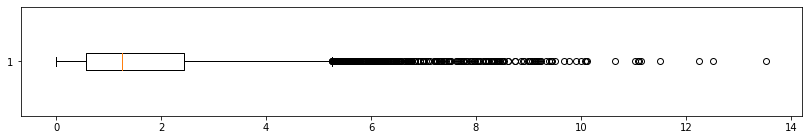

In [19]:
# abs difference
difference = abs((expected - predicted))
print('Mean Absolute Error = ', np.mean(difference))
# show boxplot
plt.figure(figsize = (14,2))
plt.boxplot(difference, vert= False);
plt.show()

### Trova numero ottimale di neuroni

number of nodes=100: 7.544
number of nodes=200: 5.957
number of nodes=300: 6.584
number of nodes=400: 5.993
number of nodes=500: 6.943
number of nodes=600: 5.934
number of nodes=700: 7.321


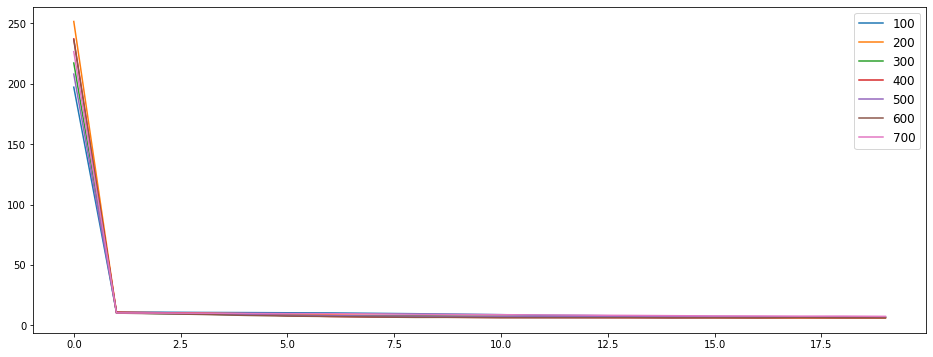

In [21]:
# fit model with given number of nodes, returns test set accuracy
def evaluate_model(n_nodes, train_X, train_y, val_X, val_y):
    
    # define model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
    model.add(MaxPooling1D(pool_size=2)) 
    model.add(Flatten())
    model.add(Dense(50, activation='relu')) 
    model.add(Dense(n_steps_out)) 
    model.compile(optimizer='adam', loss='mse')
   
    # test_X[0:672]
    history = model.fit(train_X, train_y, epochs=20, verbose=0)
    
    test_acc = model.evaluate(val_X, val_y, verbose=0)
    return history, test_acc  

plt.figure(figsize = (16, 6))
num_nodes = [100, 200, 300, 400, 500, 600, 700]

for n_nodes in num_nodes:
    # evaluate model with a given number of nodes
    history, result = evaluate_model(n_nodes, train_X, train_y, test_X, test_y)
        
    # summarize final test set accuracy
    print('number of nodes=%d: %.3f' % (n_nodes, result))
         
    # plot learning curve
    plt.plot(history.history['loss'], label=str(n_nodes))       
    
# show the plot
plt.legend(prop={'size': 12})
plt.show()

### Fermare il tranining al punto giusto con EarlyStopping - tollerare il loss con il parametro patience

Epoch 01050: early stopping
2479/2479 [==============================] - 0s 28us/step
[5.192869761401181, 1.6549320220947266, 0.5493688583374023] [5.775424164021482, 1.7333773374557495, 0.5417507290840149]
['loss', 'mean_absolute_error', 'accuracy']
['loss', 'mean_absolute_error', 'accuracy']


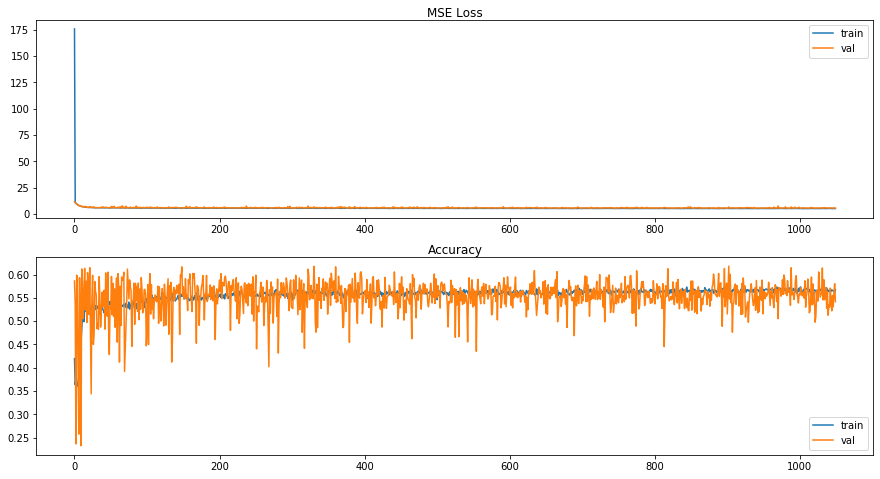

In [25]:
# import EarlyStopping
from keras.callbacks import EarlyStopping

 # define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2)) 
model.add(Flatten())
model.add(Dense(100, activation='relu')) 
model.add(Dense(n_steps_out)) 
#model.compile(optimizer='adam', loss='mse')
model.compile(loss='mse', optimizer='adam', metrics=[metrics.mae, 'accuracy'])

# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150)

# fit model
history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=4000, verbose=0, callbacks=[es]) 

# evaluate the model
train_acc = model.evaluate(train_X, train_y, verbose=1)

val_acc = model.evaluate(val_X, val_y, verbose=1)
print(train_acc, val_acc)
print(model.metrics_names)
#print('Train: %.3f, Val: %.3f' % (train_acc[2], val_acc[2]))
print(model.metrics_names)

# plot loss learning curves
plt.figure(figsize = (15, 8))
plt.subplot(211)
plt.title('MSE Loss', pad=-40)
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='val')
plt.legend()

# plot accuracy learning curves
plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history.history['accuracy'], label='train') 
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

### Salva modello 

In [26]:
model.save('CNN_MultistepForcast_early_stopping.h5')

### Calcola errore per tutte le celle

486-1252
Mean Absolute Error =  2.7466594258170507


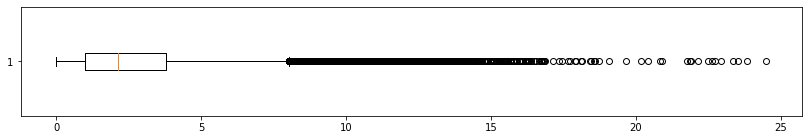

486-1253
Mean Absolute Error =  3.0475821687966405


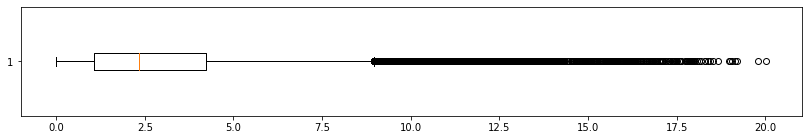

486-1254
Mean Absolute Error =  3.0270722483772854


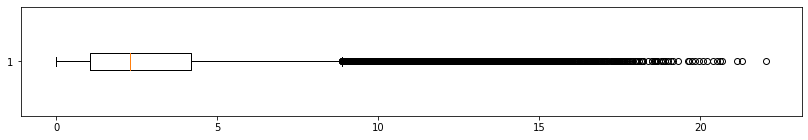

486-1255
Mean Absolute Error =  3.0628956612394687


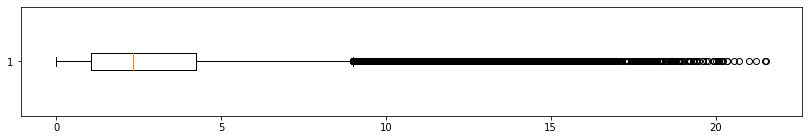

486-1256
Mean Absolute Error =  3.1059972947192533


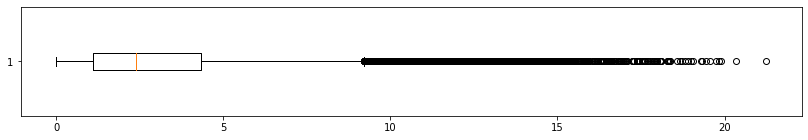

486-1257
Mean Absolute Error =  2.637774202335148


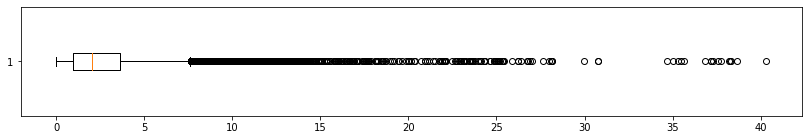

486-1258
Mean Absolute Error =  2.3783422593312933


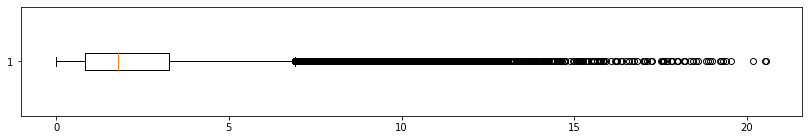

486-1259
Mean Absolute Error =  2.3953819929693965


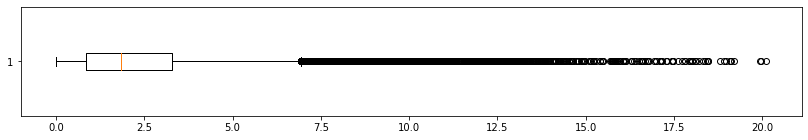

486-1260
Mean Absolute Error =  2.533332716776737


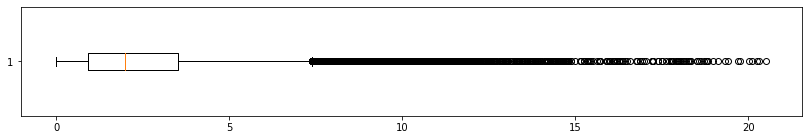

486-1261
Mean Absolute Error =  2.3208093502565217


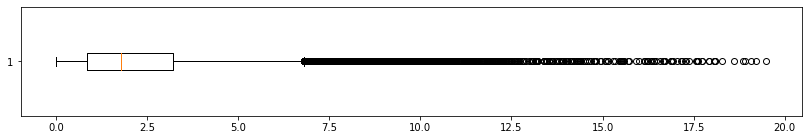

486-1262
Mean Absolute Error =  2.3904783286970646


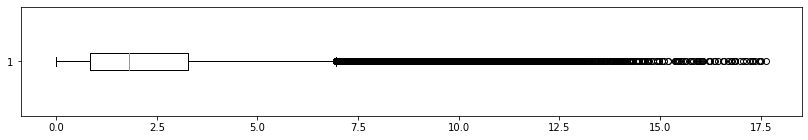

486-1263
Mean Absolute Error =  26.345546965744735


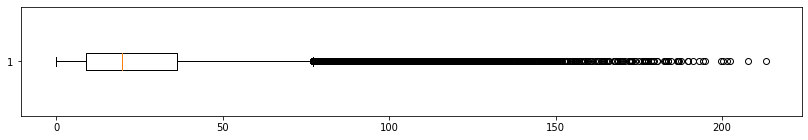

486-1264
Mean Absolute Error =  24.014002334004264


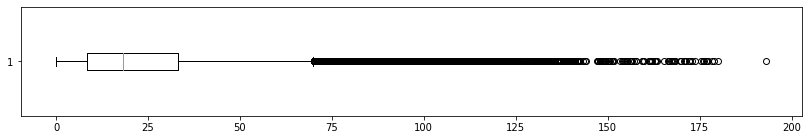

486-1265
Mean Absolute Error =  16.11063998431732


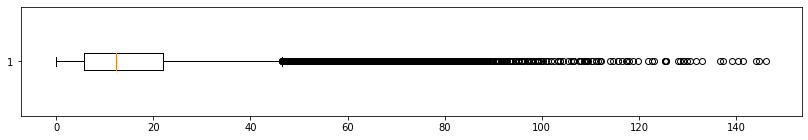

486-1266
Mean Absolute Error =  5.584212020594331


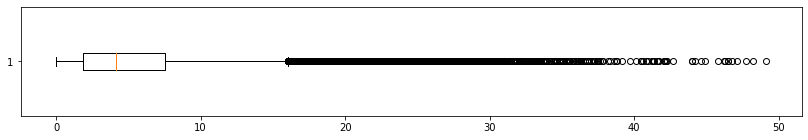

486-1267
Mean Absolute Error =  1.0874284709301112


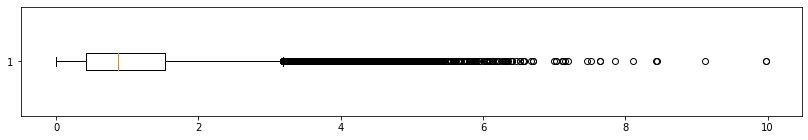

486-1268
Mean Absolute Error =  1.1149716110074108


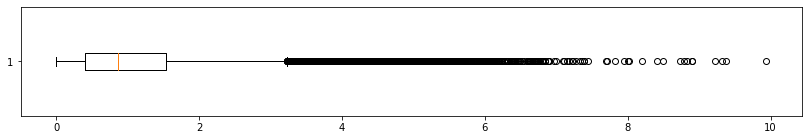

487-1252
Mean Absolute Error =  3.0727040073682237


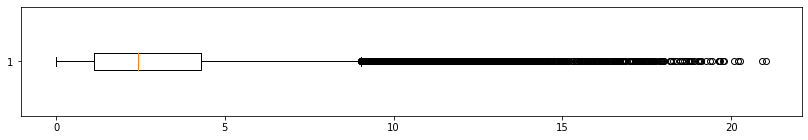

487-1253
Mean Absolute Error =  3.272440976859596


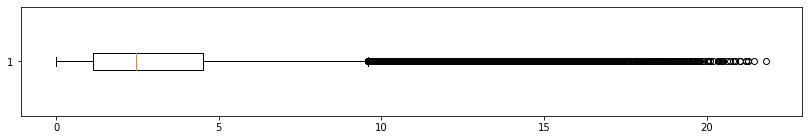

487-1254
Mean Absolute Error =  3.117851338621555


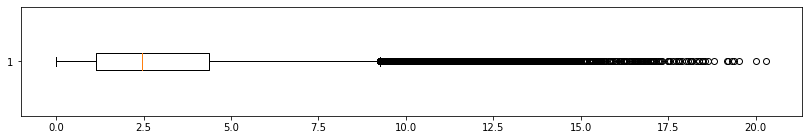

487-1255
Mean Absolute Error =  3.005487908015669


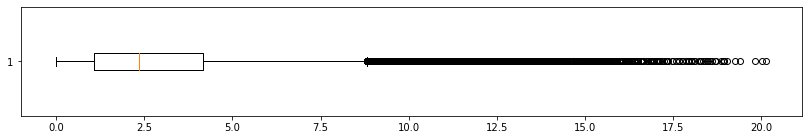

487-1256
Mean Absolute Error =  3.3900866465519983


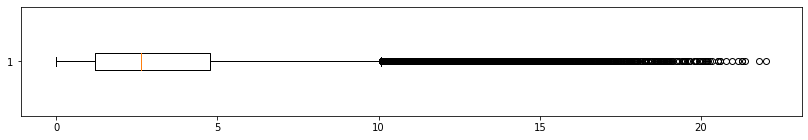

487-1257
Mean Absolute Error =  3.1532450595397328


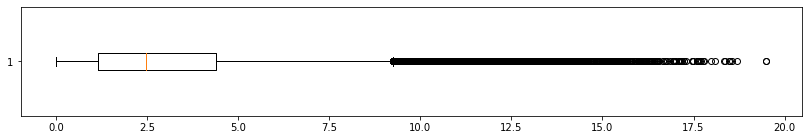

487-1258
Mean Absolute Error =  2.9154627589208286


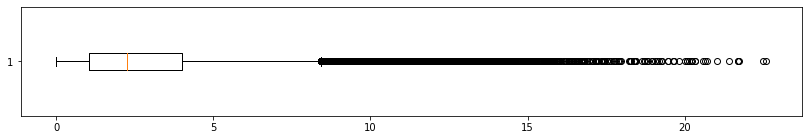

487-1259
Mean Absolute Error =  2.5895610255845454


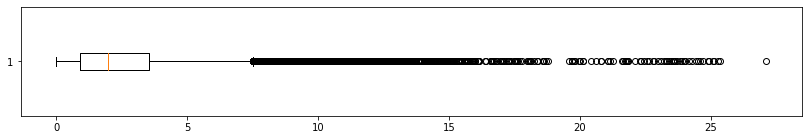

487-1260
Mean Absolute Error =  2.457314809453463


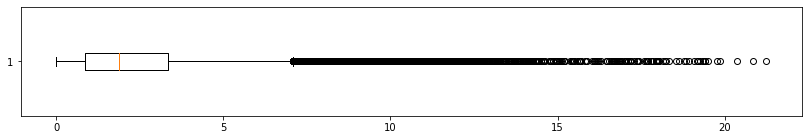

487-1261
Mean Absolute Error =  2.4413991414864533


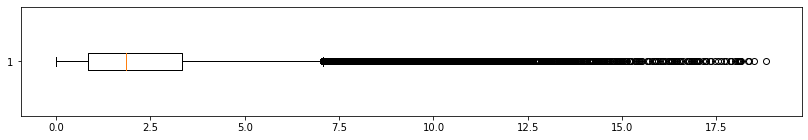

487-1262
Mean Absolute Error =  4.155696058409277


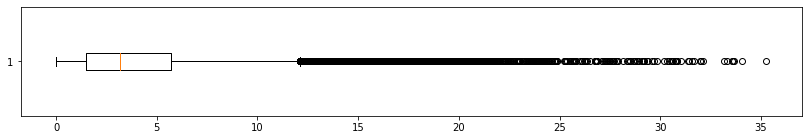

487-1263
Mean Absolute Error =  32.17524740594371


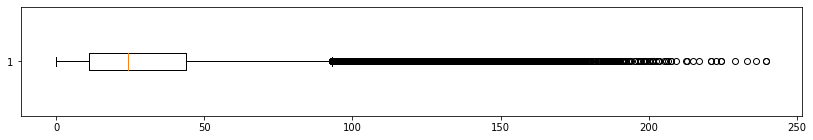

487-1264
Mean Absolute Error =  22.86943272782149


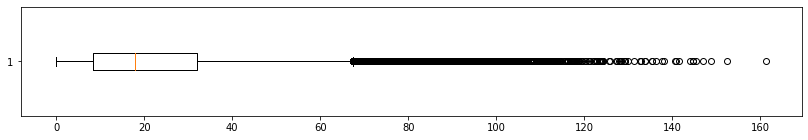

487-1265
Mean Absolute Error =  19.16324623222895


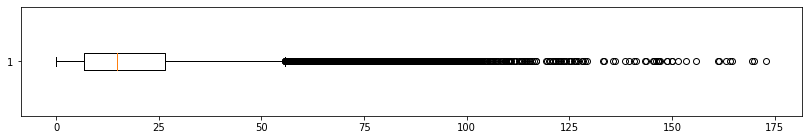

487-1266
Mean Absolute Error =  8.37095080230775


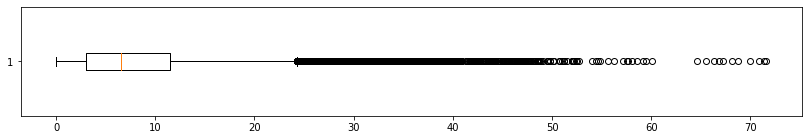

487-1267
Mean Absolute Error =  1.1028213455604197


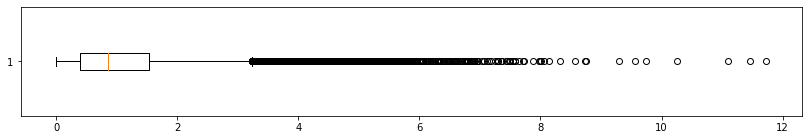

487-1268
Mean Absolute Error =  4.821296567338062


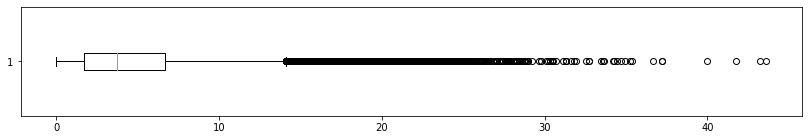

488-1252
Mean Absolute Error =  15.075576083367809


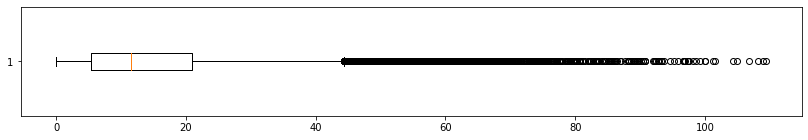

488-1253
Mean Absolute Error =  15.845406768612367


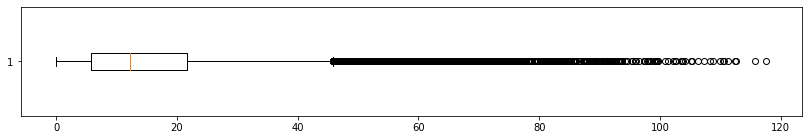

488-1254
Mean Absolute Error =  6.285904762283605


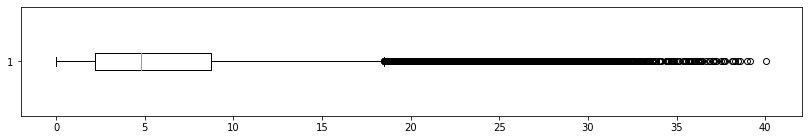

488-1255
Mean Absolute Error =  3.365026088178522


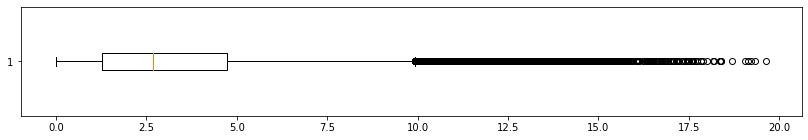

488-1256
Mean Absolute Error =  3.562326629607595


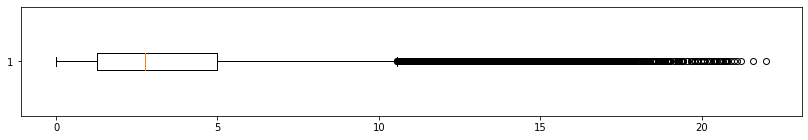

488-1257
Mean Absolute Error =  3.100395601571699


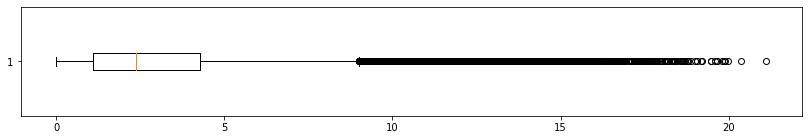

488-1258
Mean Absolute Error =  3.8897942273048667


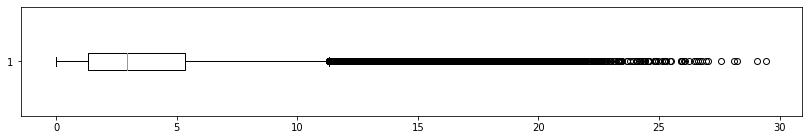

488-1259
Mean Absolute Error =  3.033961199478802


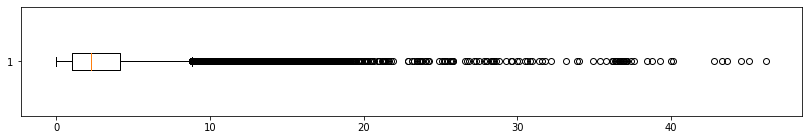

488-1260
Mean Absolute Error =  3.2337868768260822


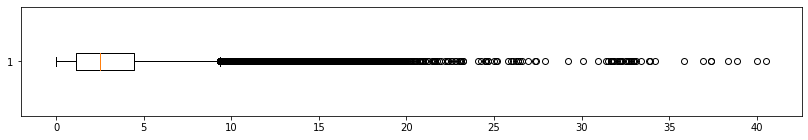

488-1261
Mean Absolute Error =  2.741650999888869


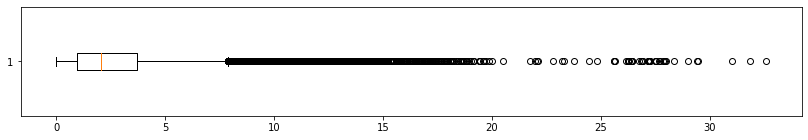

488-1262
Mean Absolute Error =  2.7992284148734843


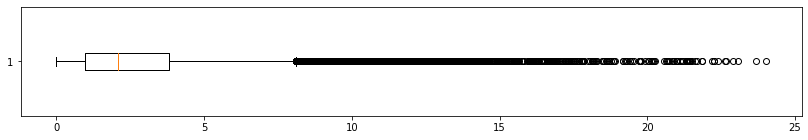

488-1263
Mean Absolute Error =  19.04815714650824


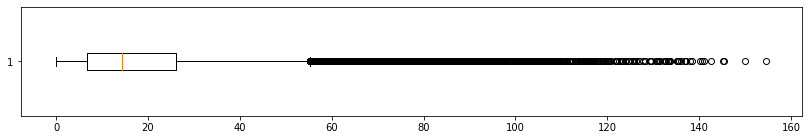

488-1264
Mean Absolute Error =  22.254928895410355


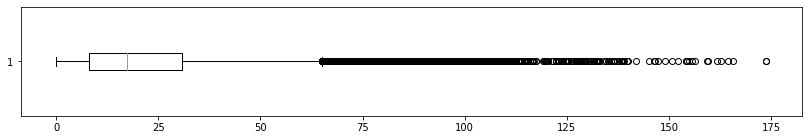

488-1265
Mean Absolute Error =  21.863333096816923


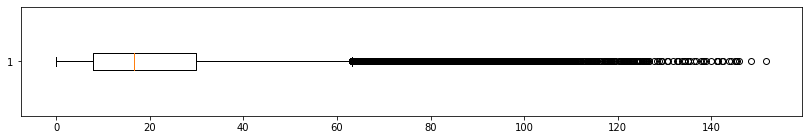

488-1266
Mean Absolute Error =  12.221714184172527


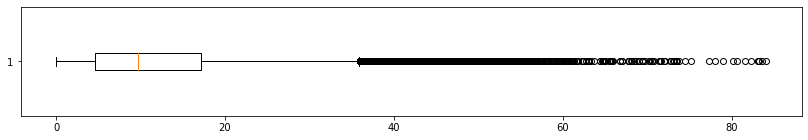

488-1267
Mean Absolute Error =  3.4921183564910576


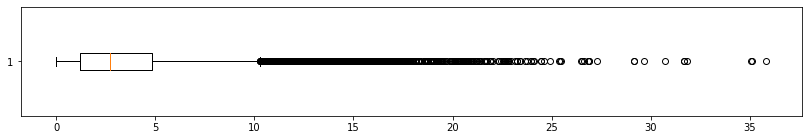

488-1268
Mean Absolute Error =  5.780135419484312


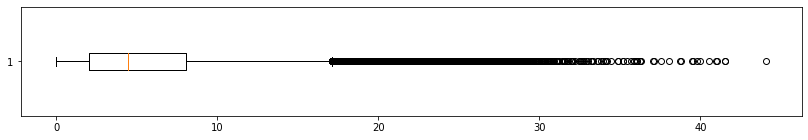

489-1252
Mean Absolute Error =  25.847543354104346


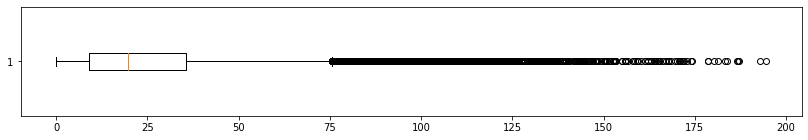

489-1253
Mean Absolute Error =  25.86220496923132


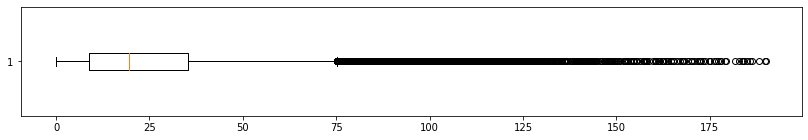

489-1254
Mean Absolute Error =  15.33055987039166


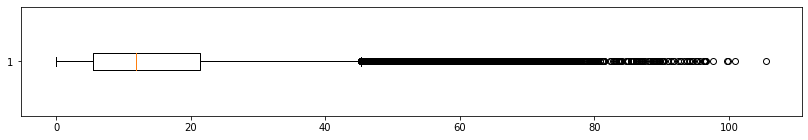

489-1255
Mean Absolute Error =  12.821637844854848


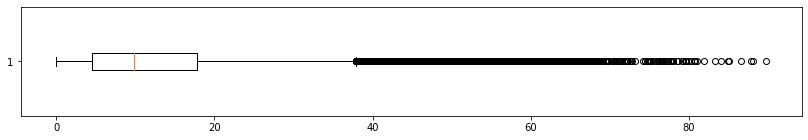

489-1256
Mean Absolute Error =  5.983319826394138


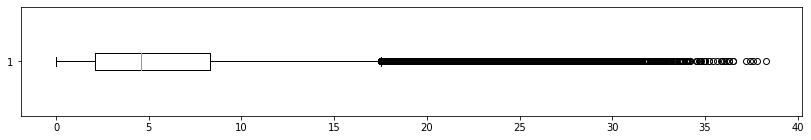

489-1257
Mean Absolute Error =  3.2049143154975597


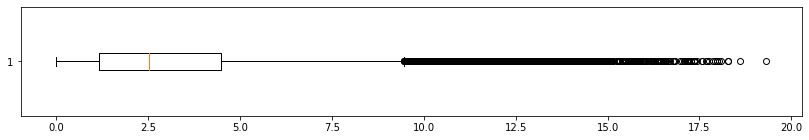

489-1258
Mean Absolute Error =  4.073777419639945


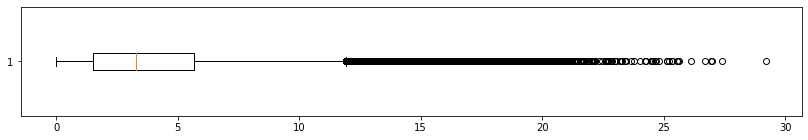

489-1259
Mean Absolute Error =  3.228668430802293


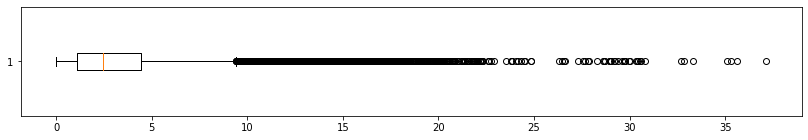

489-1260
Mean Absolute Error =  3.152967079488906


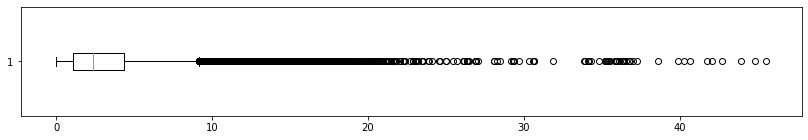

489-1261
Mean Absolute Error =  3.158609967948463


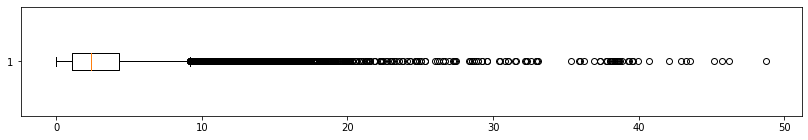

489-1262
Mean Absolute Error =  3.4940251060843224


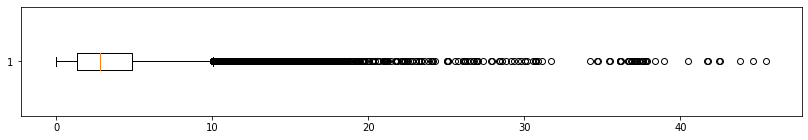

489-1263
Mean Absolute Error =  2.423992304566921


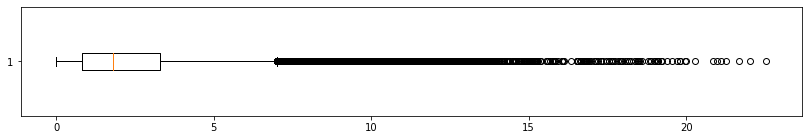

489-1264
Mean Absolute Error =  4.832518908032575


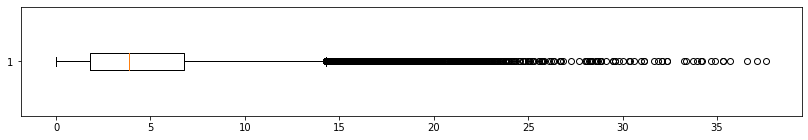

489-1265
Mean Absolute Error =  8.930155378353328


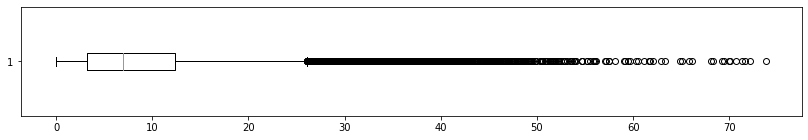

489-1266
Mean Absolute Error =  12.898033537761743


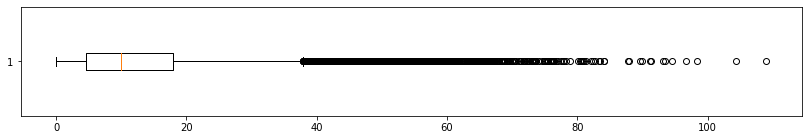

489-1267
Mean Absolute Error =  4.161445886926593


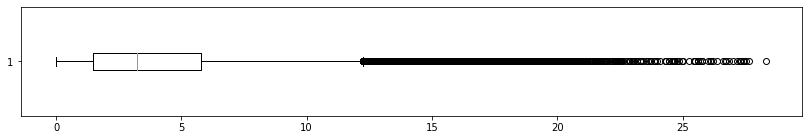

489-1268
Mean Absolute Error =  5.953508600984717


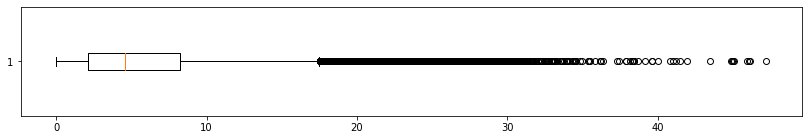

490-1252
Mean Absolute Error =  14.401840901609836


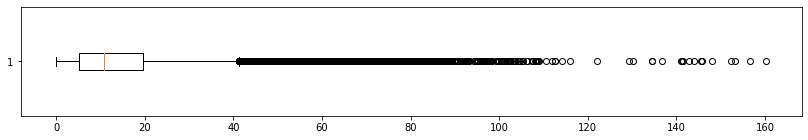

490-1253
Mean Absolute Error =  6.028280160938892


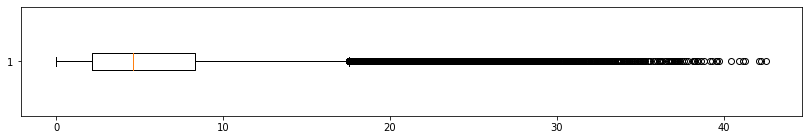

490-1254
Mean Absolute Error =  28.336460109112462


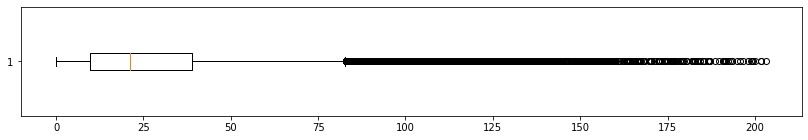

490-1255
Mean Absolute Error =  8.15183502930682


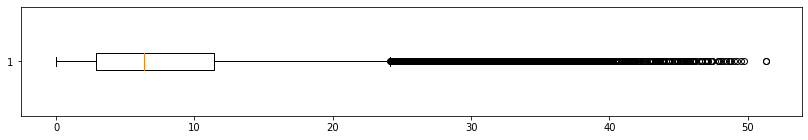

490-1256
Mean Absolute Error =  27.02347520207485


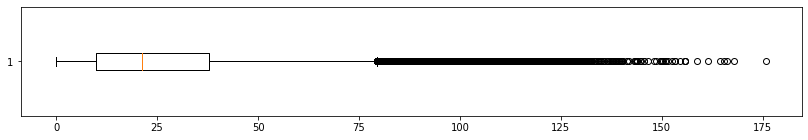

490-1257
Mean Absolute Error =  9.551597175675838


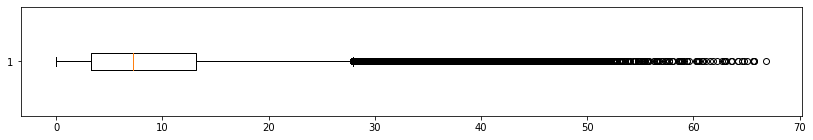

490-1258
Mean Absolute Error =  3.5449569996136514


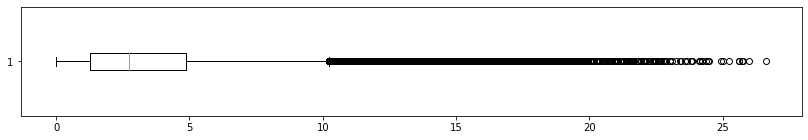

490-1259
Mean Absolute Error =  3.0410037145362123


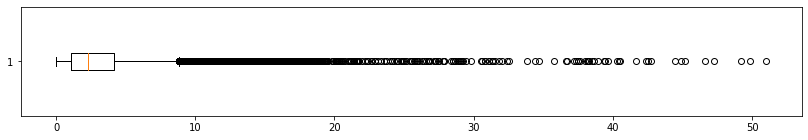

490-1260
Mean Absolute Error =  3.116971050161451


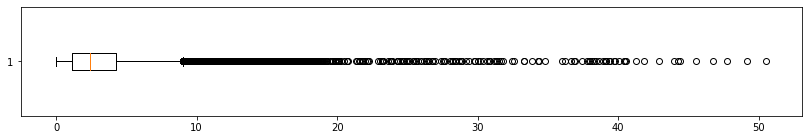

490-1261
Mean Absolute Error =  3.0772069336372576


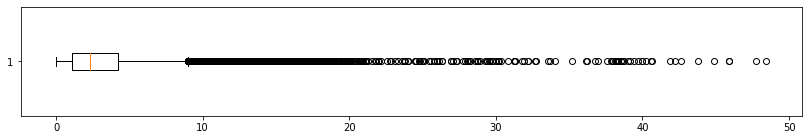

490-1262
Mean Absolute Error =  2.8149164788582173


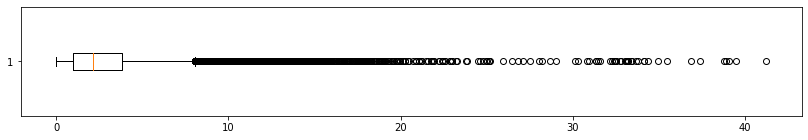

490-1263
Mean Absolute Error =  2.205582896650202


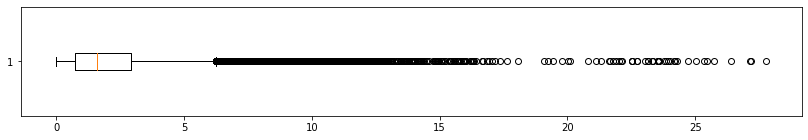

490-1264
Mean Absolute Error =  1.6116116811748435


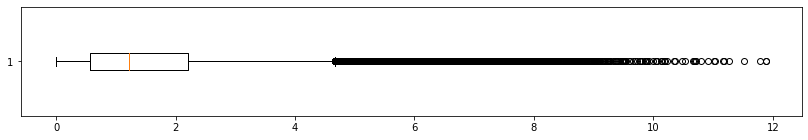

490-1265
Mean Absolute Error =  1.257206642026571


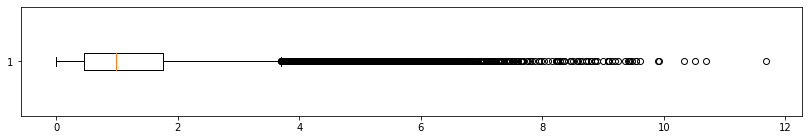

490-1266
Mean Absolute Error =  1.8408894861846736


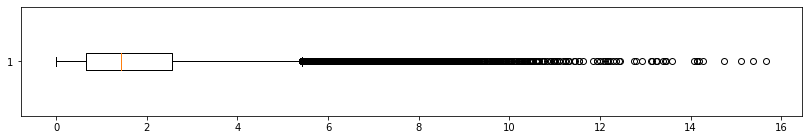

490-1267
Mean Absolute Error =  2.4633498640196385


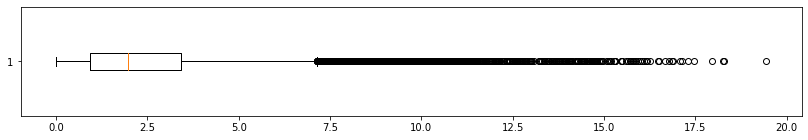

490-1268
Mean Absolute Error =  5.912228216788919


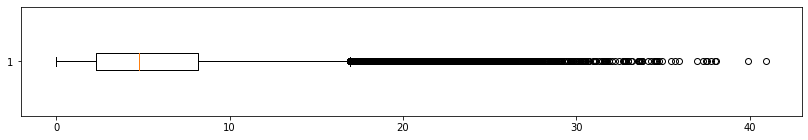

491-1252
Mean Absolute Error =  3.4932399232013647


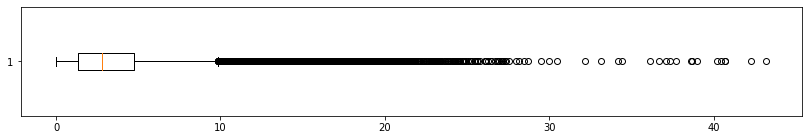

491-1253
Mean Absolute Error =  3.164191192471568


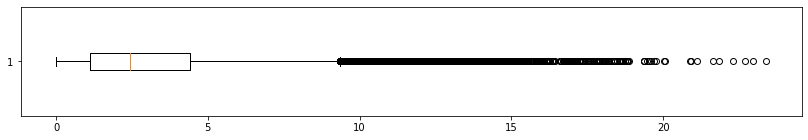

491-1254
Mean Absolute Error =  7.125957261716761


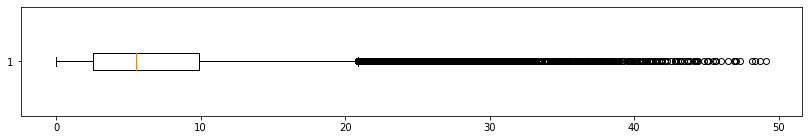

491-1255
Mean Absolute Error =  16.824632634864077


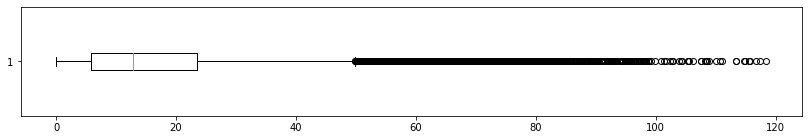

491-1256
Mean Absolute Error =  14.4134863756106


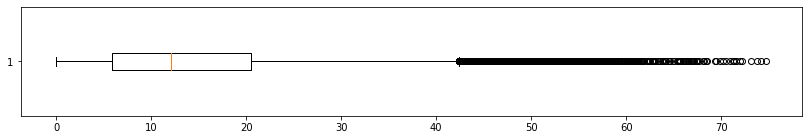

491-1257
Mean Absolute Error =  14.252234530757741


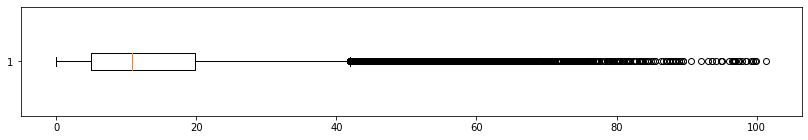

491-1258
Mean Absolute Error =  74.20746692416624


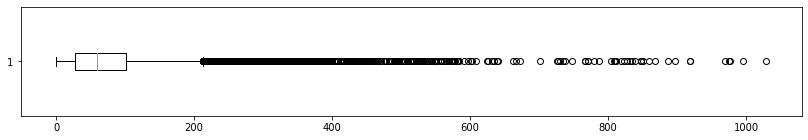

491-1259
Mean Absolute Error =  74.56526459374204


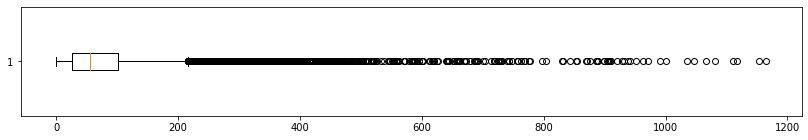

491-1260
Mean Absolute Error =  18.858669951211652


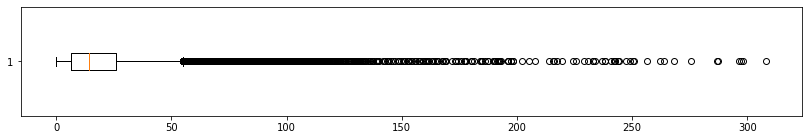

491-1261
Mean Absolute Error =  2.1651896068938155


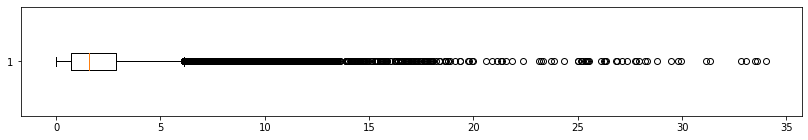

491-1262
Mean Absolute Error =  3.5777487022570824


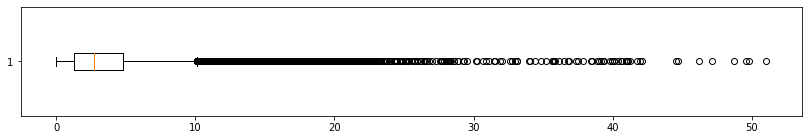

491-1263
Mean Absolute Error =  1.792289269317192


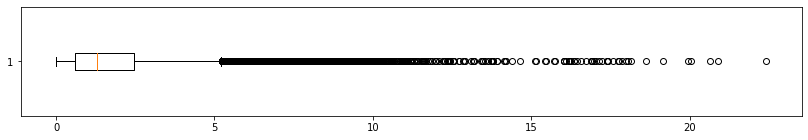

491-1264
Mean Absolute Error =  1.5067478690370766


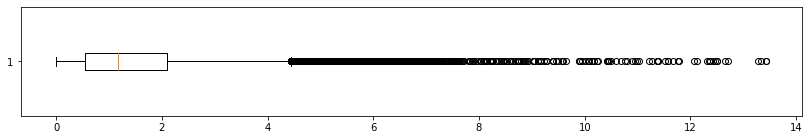

491-1265
Mean Absolute Error =  1.1767235738595003


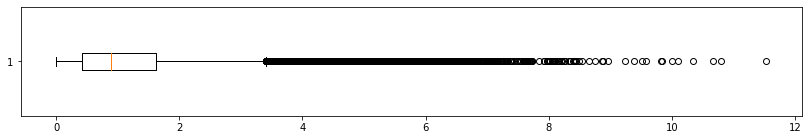

491-1266
Mean Absolute Error =  0.9910235965674375


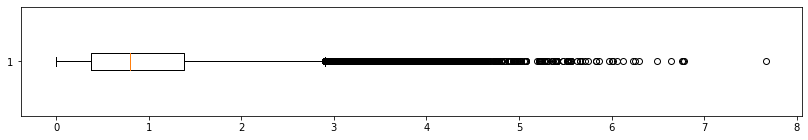

491-1267
Mean Absolute Error =  0.6157468013413812


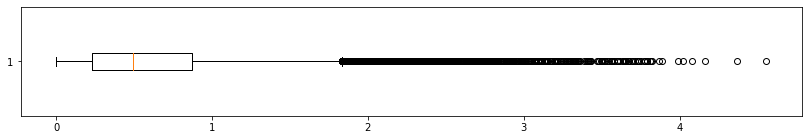

491-1268
Mean Absolute Error =  7.981003769014129


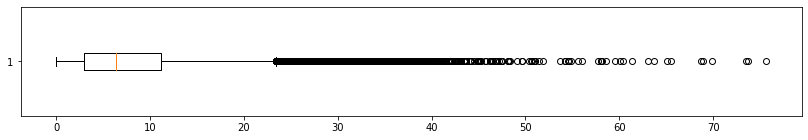

492-1252
Mean Absolute Error =  4.993106474182999


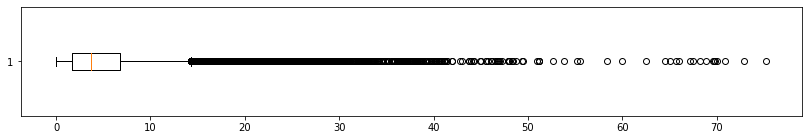

492-1253
Mean Absolute Error =  5.495599172432894


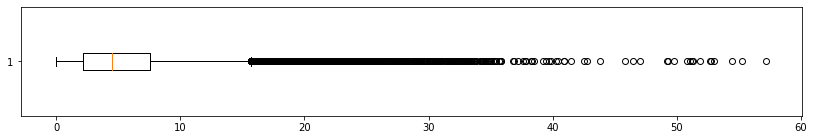

492-1254
Mean Absolute Error =  12.99771919825412


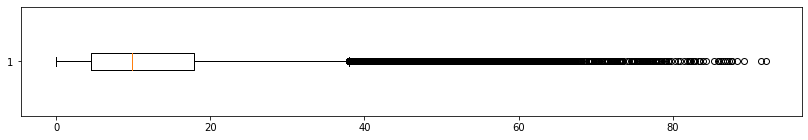

492-1255
Mean Absolute Error =  17.374581049217955


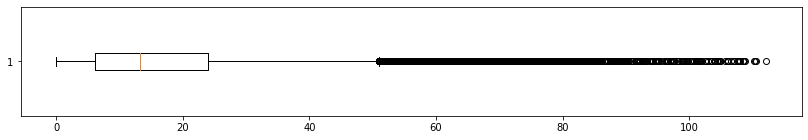

492-1256
Mean Absolute Error =  18.678815541191646


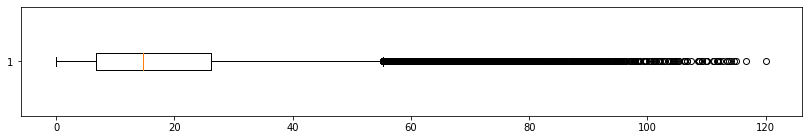

492-1257
Mean Absolute Error =  13.836050781622923


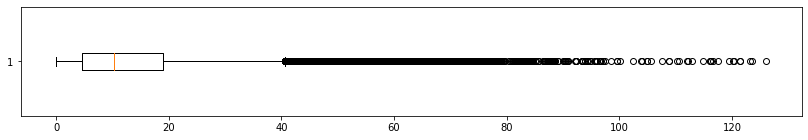

492-1258
Mean Absolute Error =  46.02504746968877


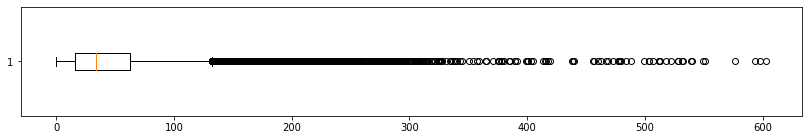

492-1259
Mean Absolute Error =  10.83847330899054


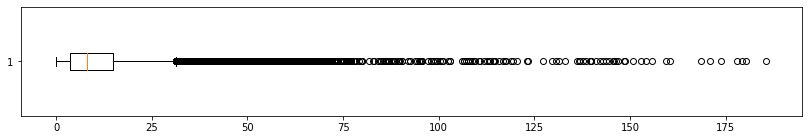

492-1260
Mean Absolute Error =  26.35381342037535


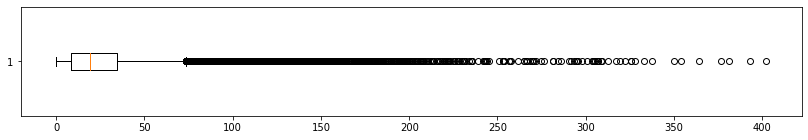

492-1261
Mean Absolute Error =  17.41267572866778


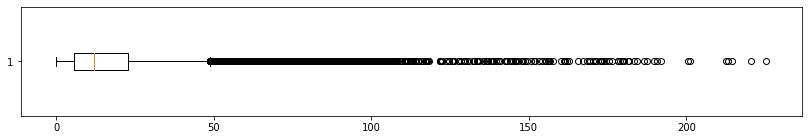

492-1262
Mean Absolute Error =  3.050837343825828


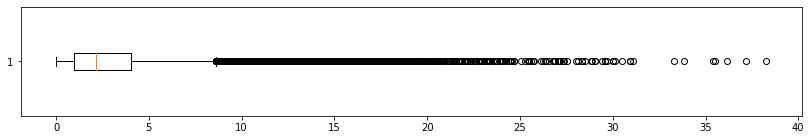

492-1263
Mean Absolute Error =  1.6008012989300575


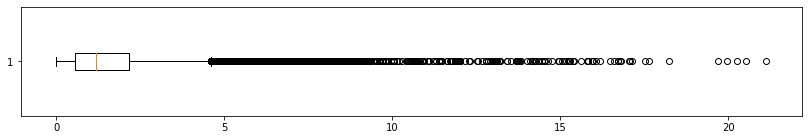

492-1264
Mean Absolute Error =  1.4594774007078586


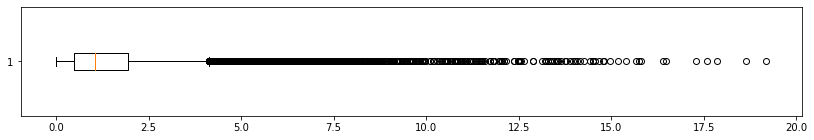

492-1265
Mean Absolute Error =  1.1379159125737892


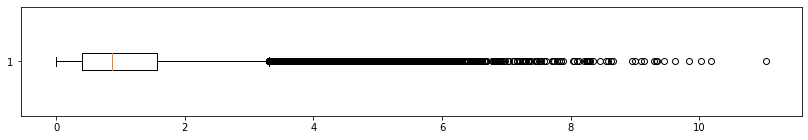

492-1266
Mean Absolute Error =  1.018928257617834


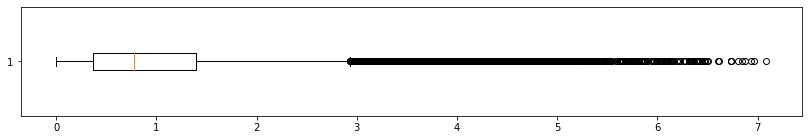

492-1267
Mean Absolute Error =  1.6726547517795913


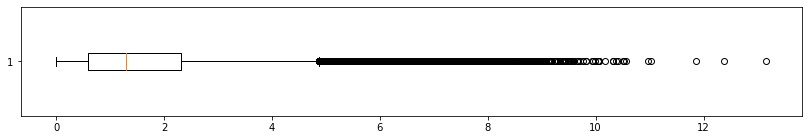

492-1268
Mean Absolute Error =  7.039324702307551


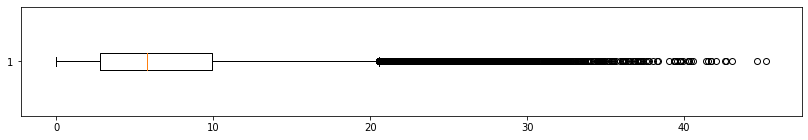

493-1252
Mean Absolute Error =  1.2796142160761381


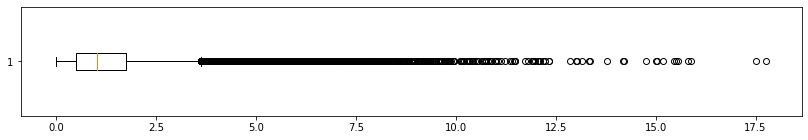

493-1253
Mean Absolute Error =  5.964529220363516


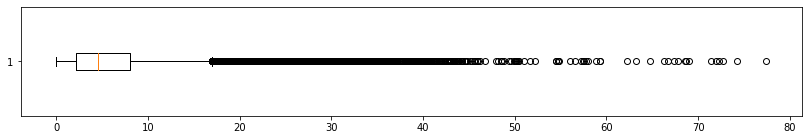

493-1254
Mean Absolute Error =  20.140658299587894


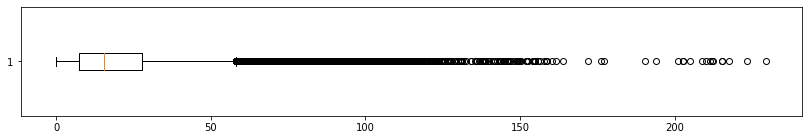

493-1255
Mean Absolute Error =  7.644949503974371


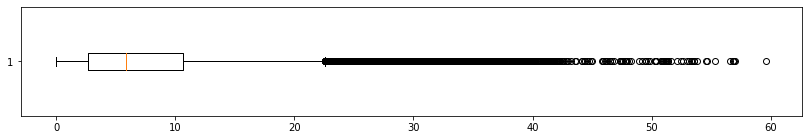

493-1256
Mean Absolute Error =  7.035965450248019


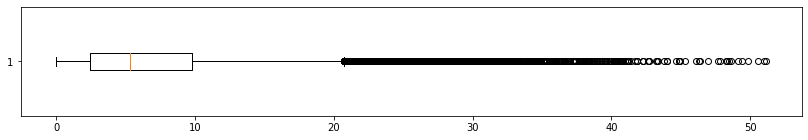

493-1257
Mean Absolute Error =  5.585690431862887


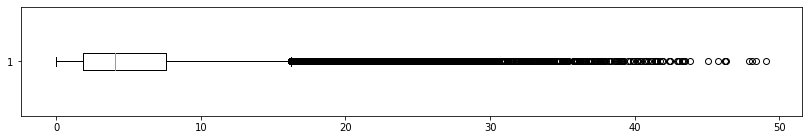

493-1258
Mean Absolute Error =  17.994487818203243


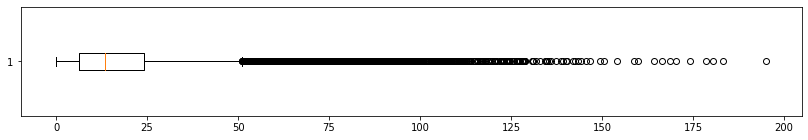

493-1259
Mean Absolute Error =  7.290264253822218


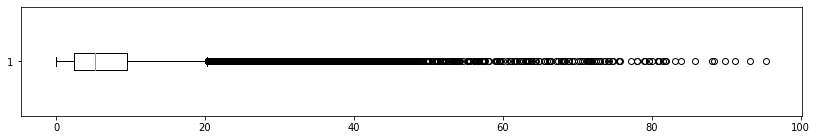

493-1260
Mean Absolute Error =  42.730601718630666


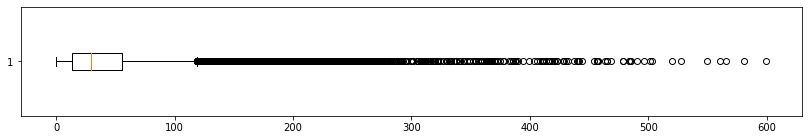

493-1261
Mean Absolute Error =  12.600825348459775


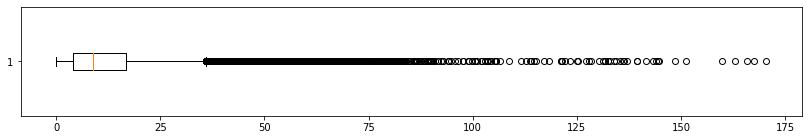

493-1262
Mean Absolute Error =  1.5297043918834927


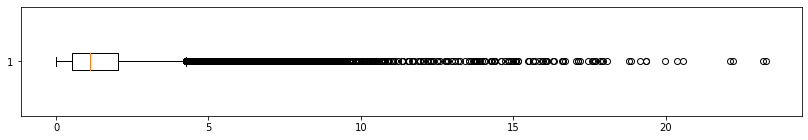

493-1263
Mean Absolute Error =  1.5158444396910502


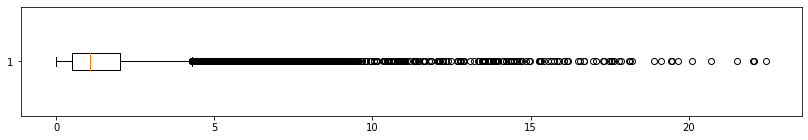

493-1264
Mean Absolute Error =  1.5492844176593477


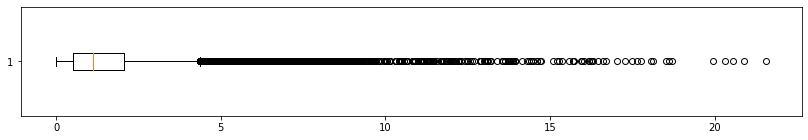

493-1265
Mean Absolute Error =  1.5305308516399438


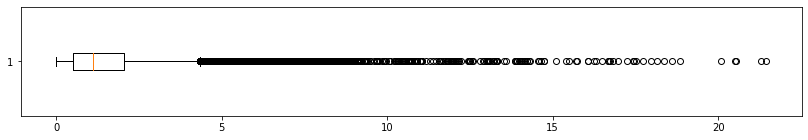

493-1266
Mean Absolute Error =  0.8441550680187715


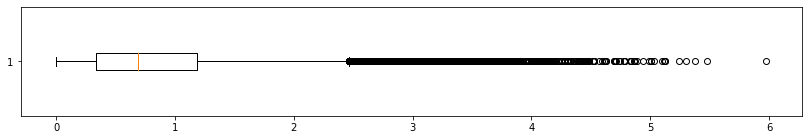

493-1267
Mean Absolute Error =  3.2654702648776612


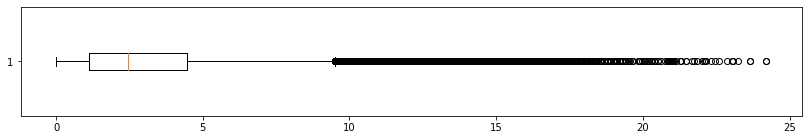

493-1268
Mean Absolute Error =  5.106178763892646


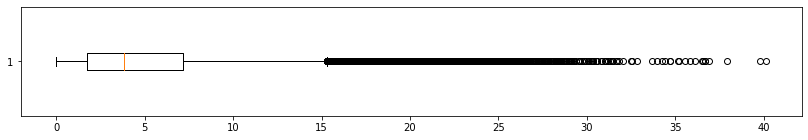

494-1252
Mean Absolute Error =  2.652366813084744


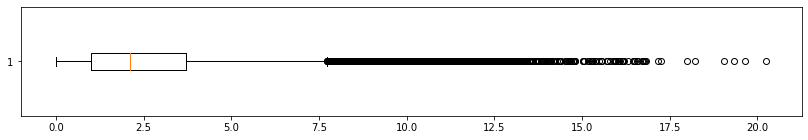

494-1253
Mean Absolute Error =  2.342854232446239


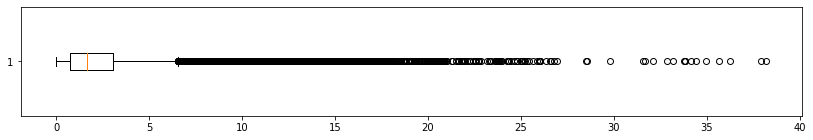

494-1254
Mean Absolute Error =  10.873707648003418


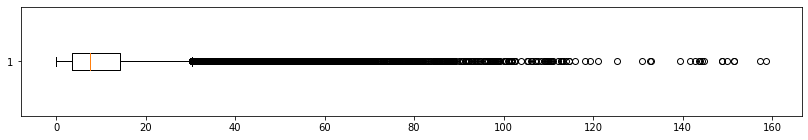

494-1255
Mean Absolute Error =  16.331909432032443


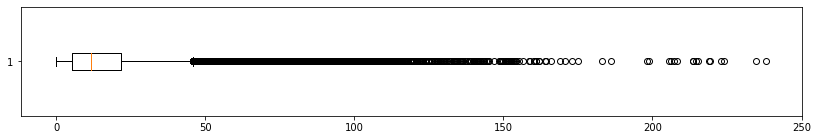

494-1256
Mean Absolute Error =  9.843702250742863


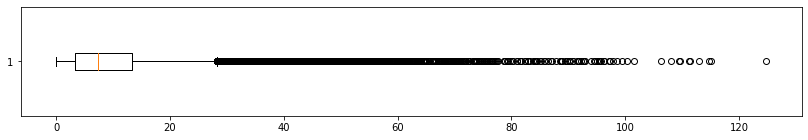

494-1257
Mean Absolute Error =  13.07773688415403


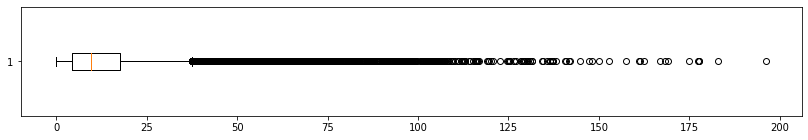

494-1258
Mean Absolute Error =  5.6912699057895635


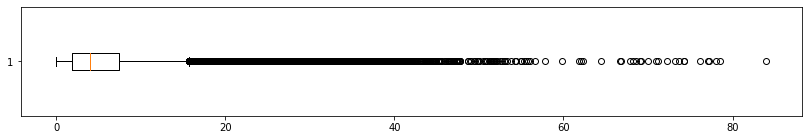

494-1259
Mean Absolute Error =  5.937865958157479


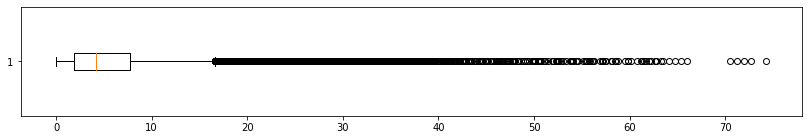

494-1260
Mean Absolute Error =  3.305574597484954


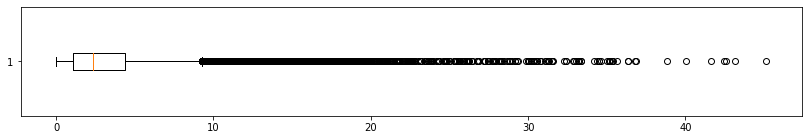

494-1261
Mean Absolute Error =  1.7592399897216051


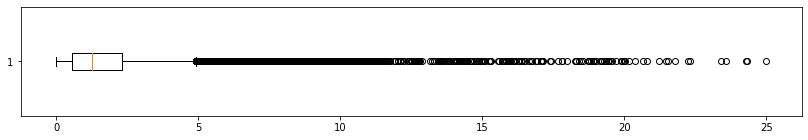

494-1262
Mean Absolute Error =  1.5567399471306267


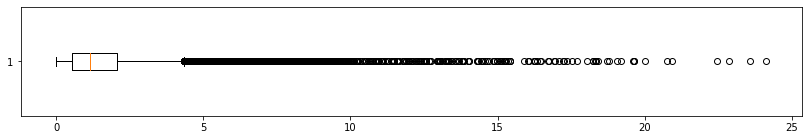

494-1263
Mean Absolute Error =  1.535123557609356


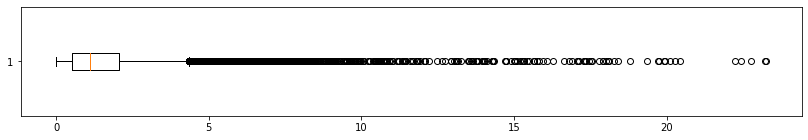

494-1264
Mean Absolute Error =  1.6053107772951456


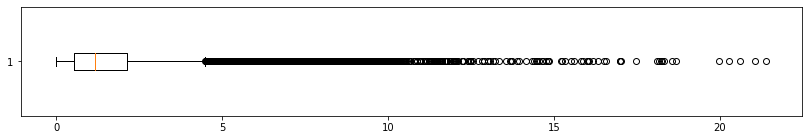

494-1265
Mean Absolute Error =  1.2636884903762102


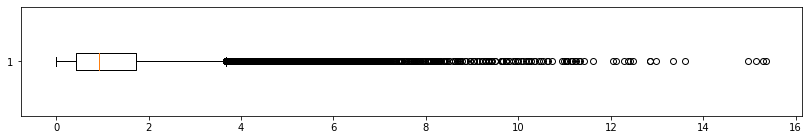

494-1266
Mean Absolute Error =  0.6607043995439642


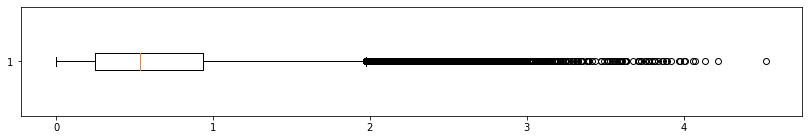

494-1267
Mean Absolute Error =  5.635608415094753


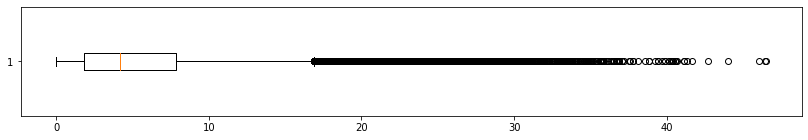

494-1268
Mean Absolute Error =  11.76563242615119


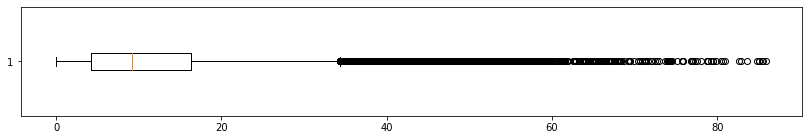

495-1252
Mean Absolute Error =  0.9520644582526989


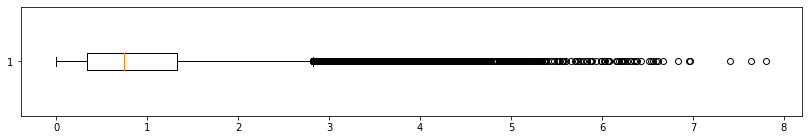

495-1253
Mean Absolute Error =  1.1028292994606033


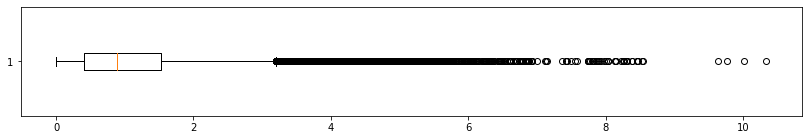

495-1254
Mean Absolute Error =  1.6906441149740743


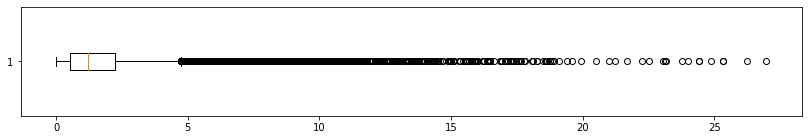

495-1255
Mean Absolute Error =  5.608444876303741


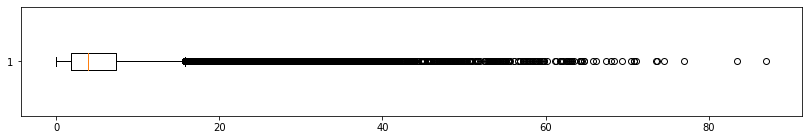

495-1256
Mean Absolute Error =  16.178821547622835


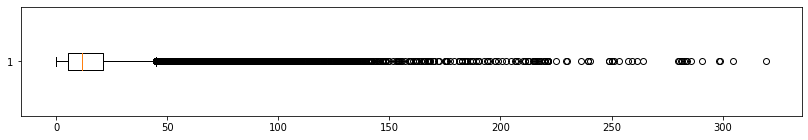

495-1257
Mean Absolute Error =  17.80559034595373


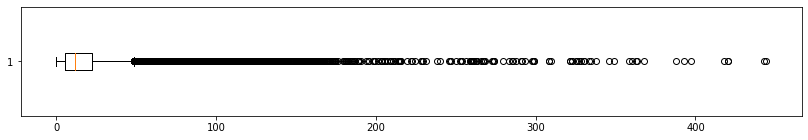

495-1258
Mean Absolute Error =  21.00727642088849


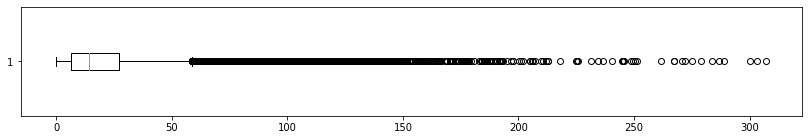

495-1259
Mean Absolute Error =  11.948727505126456


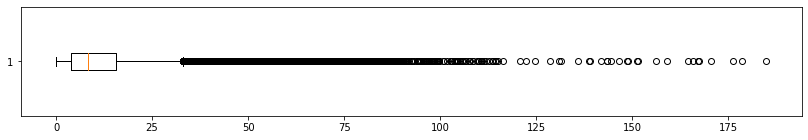

495-1260
Mean Absolute Error =  12.132759675626113


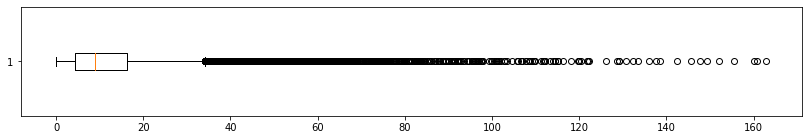

495-1261
Mean Absolute Error =  24.71235102374976


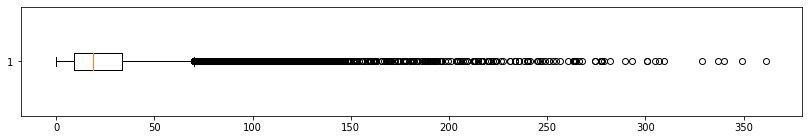

495-1262
Mean Absolute Error =  28.464526559616058


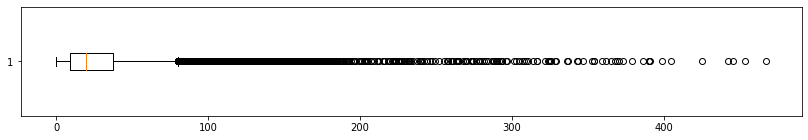

495-1263
Mean Absolute Error =  28.8801879226467


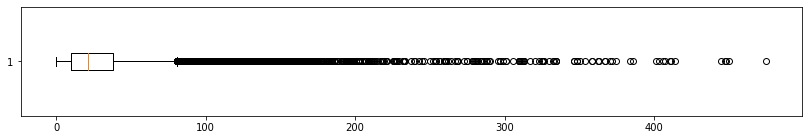

495-1264
Mean Absolute Error =  26.17147648990421


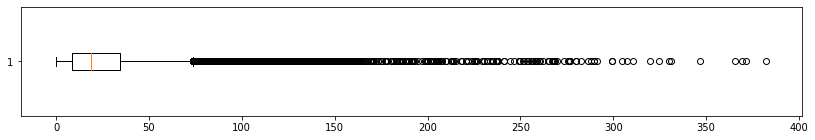

495-1265
Mean Absolute Error =  15.867364707309699


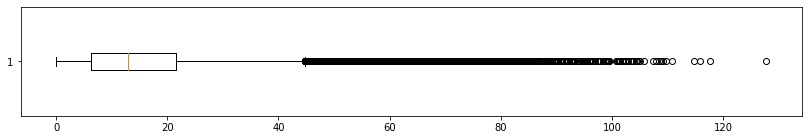

495-1266
Mean Absolute Error =  12.607932772075086


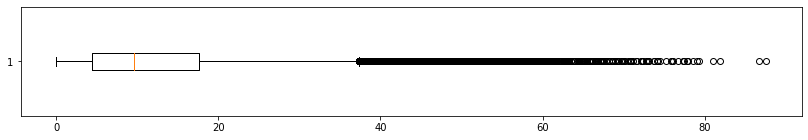

495-1267
Mean Absolute Error =  13.849905041976276


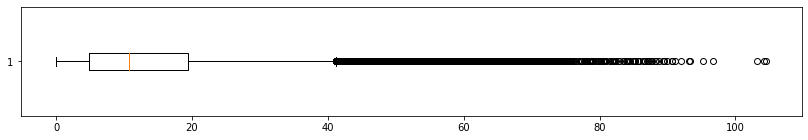

495-1268
Mean Absolute Error =  4.803680755428773


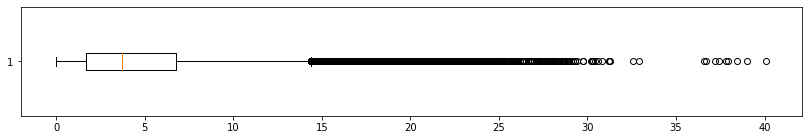

496-1252
Mean Absolute Error =  11.638360208608468


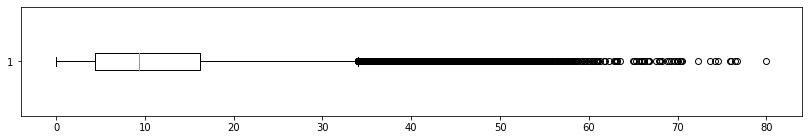

496-1253
Mean Absolute Error =  10.534040146713101


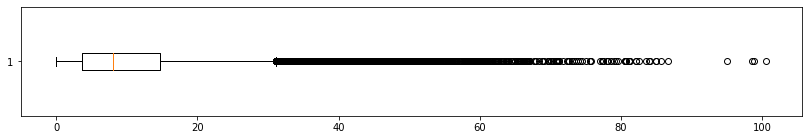

496-1254
Mean Absolute Error =  7.1624495608452134


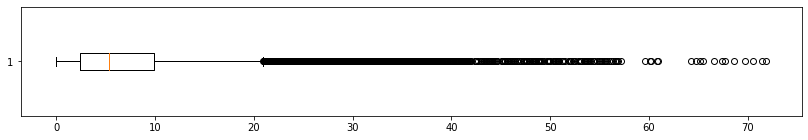

496-1255
Mean Absolute Error =  17.113505184134738


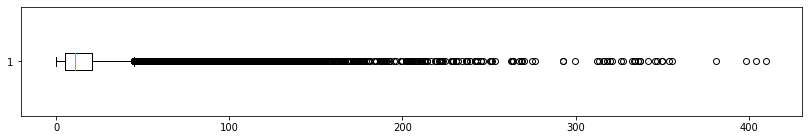

496-1256
Mean Absolute Error =  18.955011908692402


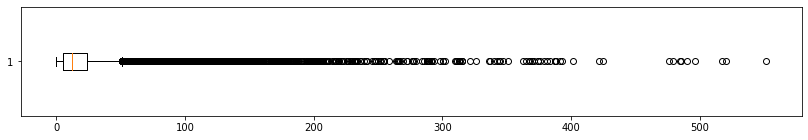

496-1257
Mean Absolute Error =  14.802207980713387


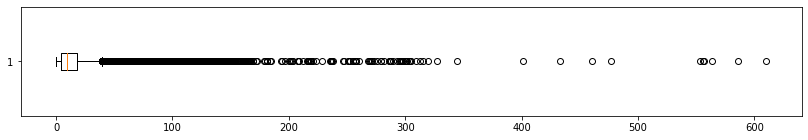

496-1258
Mean Absolute Error =  14.033849407747661


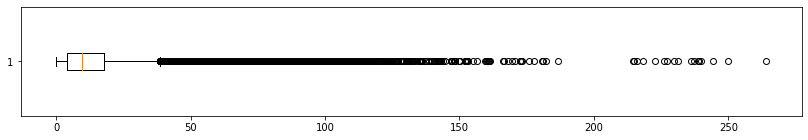

496-1259
Mean Absolute Error =  15.077710958632336


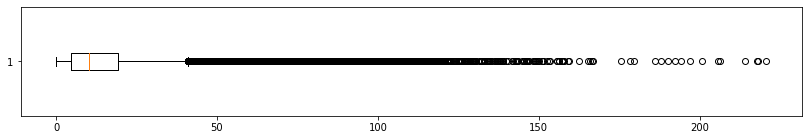

496-1260
Mean Absolute Error =  10.623377345689203


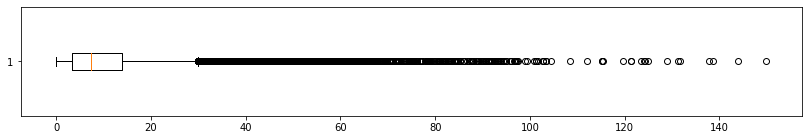

496-1261
Mean Absolute Error =  1.7530943994463826


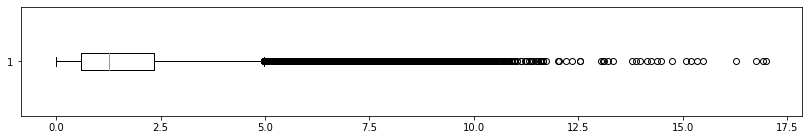

496-1262
Mean Absolute Error =  1.0880232807788732


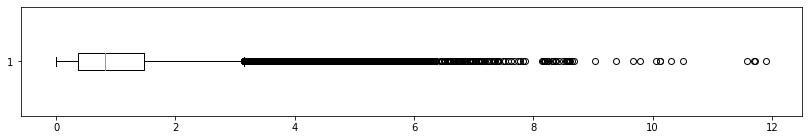

496-1263
Mean Absolute Error =  1.0331253164101035


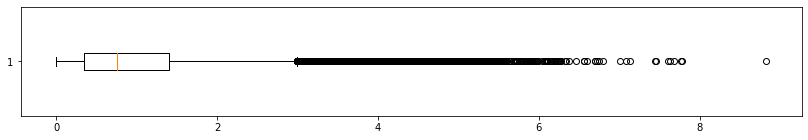

496-1264
Mean Absolute Error =  0.7155930259533666


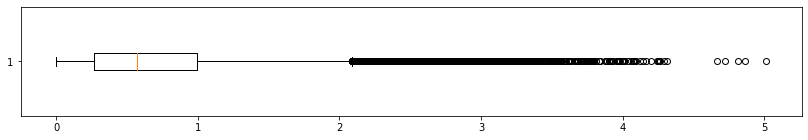

496-1265
Mean Absolute Error =  0.8266785103201624


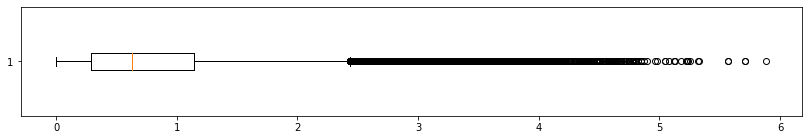

496-1266
Mean Absolute Error =  0.7675293979994391


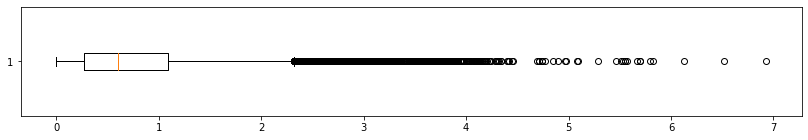

496-1267
Mean Absolute Error =  0.7402664781403396


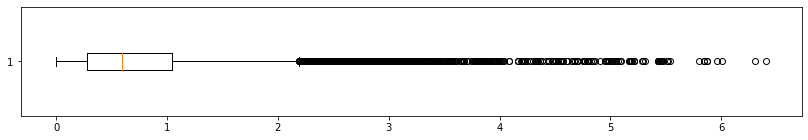

496-1268
Mean Absolute Error =  1.2829223216691958


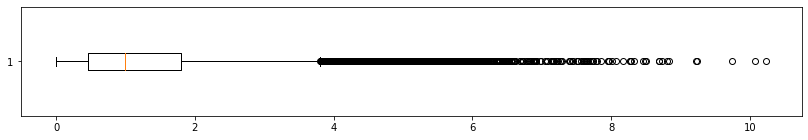

497-1252
Mean Absolute Error =  1.9188540298865915


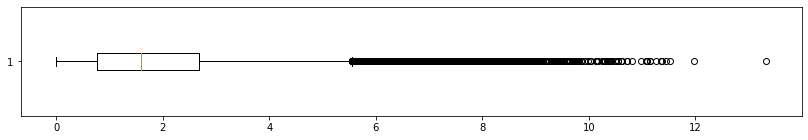

497-1253
Mean Absolute Error =  0.7109860136261297


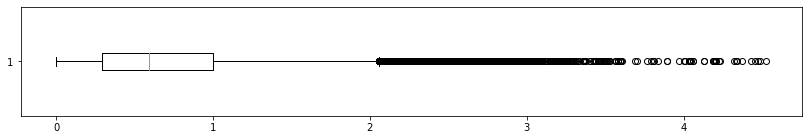

497-1254
Mean Absolute Error =  13.713704855862558


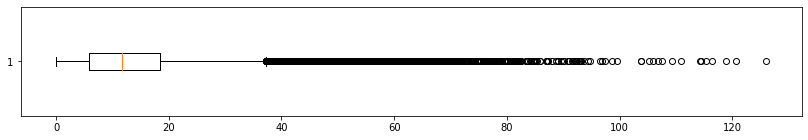

497-1255
Mean Absolute Error =  11.54352438223969


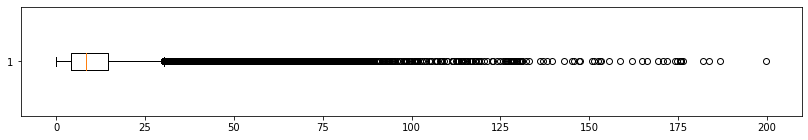

497-1256
Mean Absolute Error =  2.6005344020120966


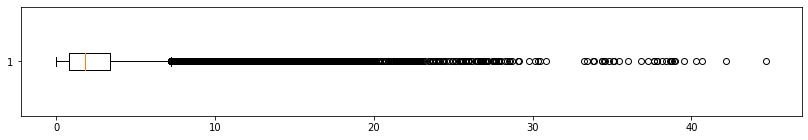

497-1257
Mean Absolute Error =  5.564316792723118


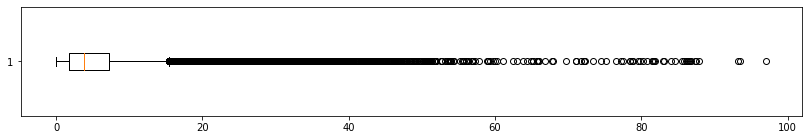

497-1258
Mean Absolute Error =  7.620981542769857


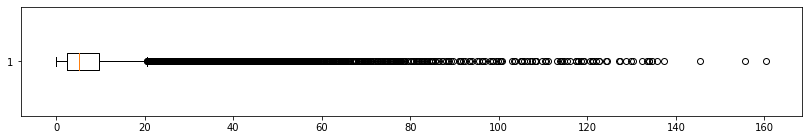

497-1259
Mean Absolute Error =  9.953416756748425


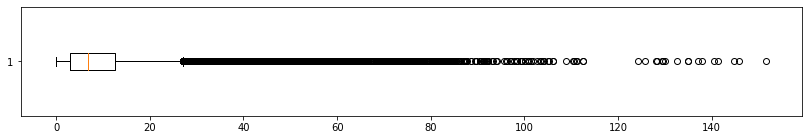

497-1260
Mean Absolute Error =  6.530360607139448


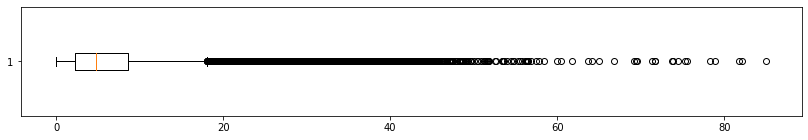

497-1261
Mean Absolute Error =  1.500603127815573


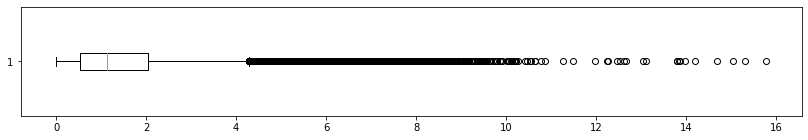

497-1262
Mean Absolute Error =  0.8715489615228657


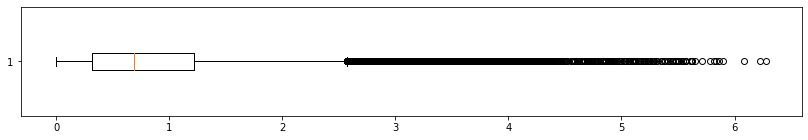

497-1263
Mean Absolute Error =  0.6550765627299695


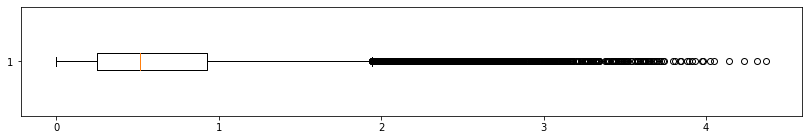

497-1264
Mean Absolute Error =  0.8500623929243224


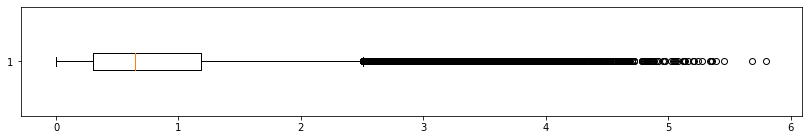

497-1265
Mean Absolute Error =  0.8905118422498528


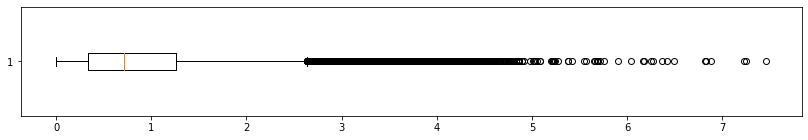

497-1266
Mean Absolute Error =  0.7488433098880434


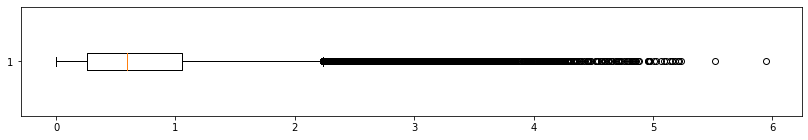

497-1267
Mean Absolute Error =  0.6936433666252556


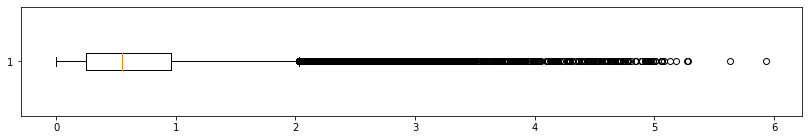

497-1268
Mean Absolute Error =  4.286157995282268


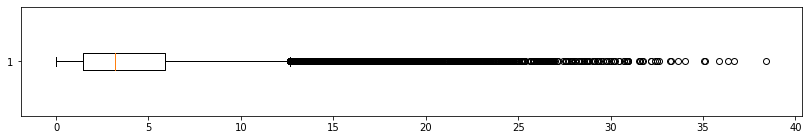

498-1252
Mean Absolute Error =  4.79624297001794


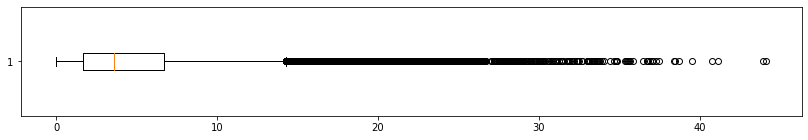

498-1253
Mean Absolute Error =  7.233830474667053


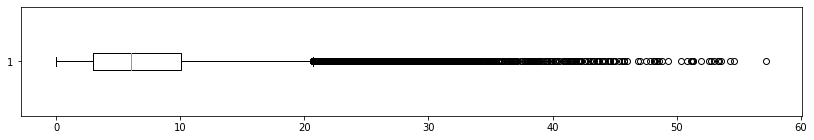

498-1254
Mean Absolute Error =  7.2969554911999985


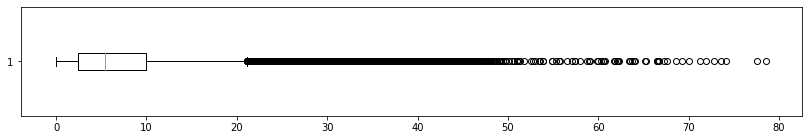

498-1255
Mean Absolute Error =  0.6040307609262874


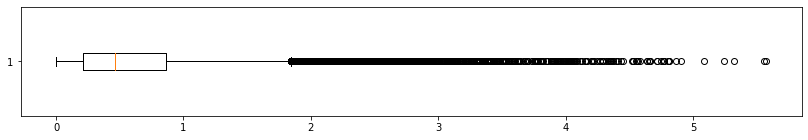

498-1256
Mean Absolute Error =  2.949172361665248


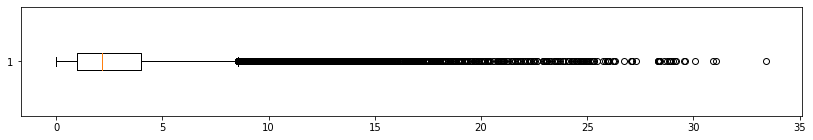

498-1257
Mean Absolute Error =  4.887929936861555


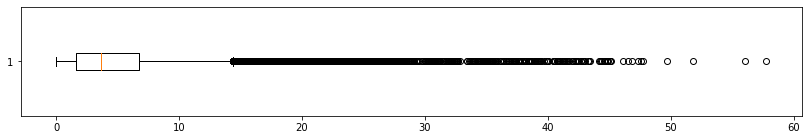

498-1258
Mean Absolute Error =  5.007611579724096


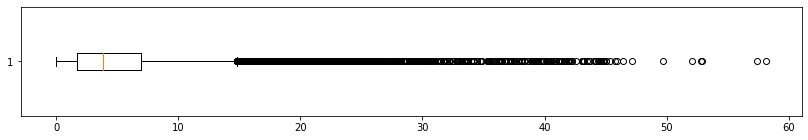

498-1259
Mean Absolute Error =  5.621625754548673


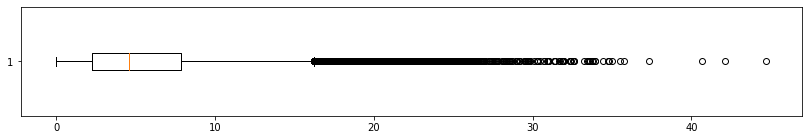

498-1260
Mean Absolute Error =  6.067907405814426


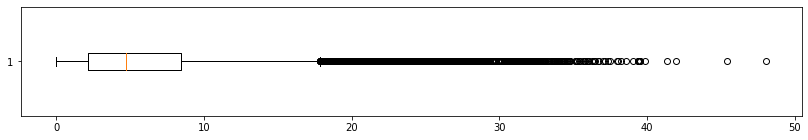

498-1261
Mean Absolute Error =  2.965144386369196


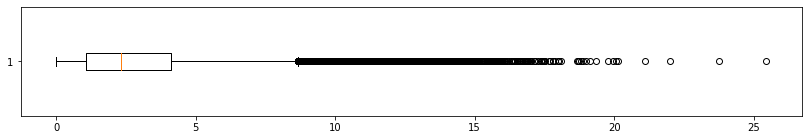

498-1262
Mean Absolute Error =  0.6236722565940345


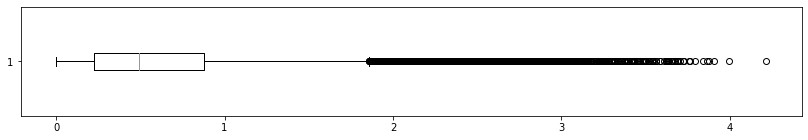

498-1263
Mean Absolute Error =  0.6534219182280562


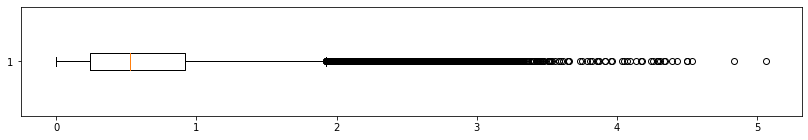

498-1264
Mean Absolute Error =  0.7962356908607872


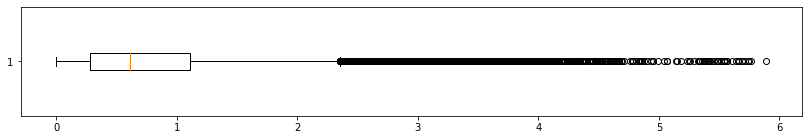

498-1265
Mean Absolute Error =  0.687084141298127


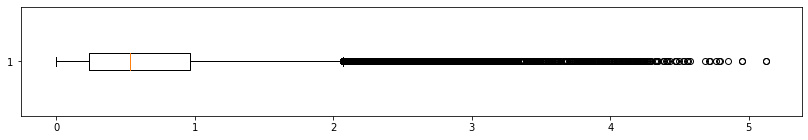

498-1266
Mean Absolute Error =  0.7397840918329243


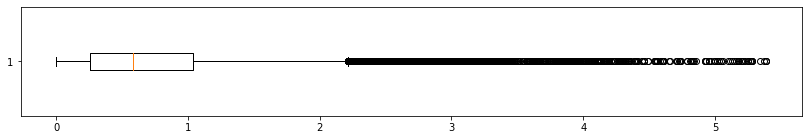

498-1267
Mean Absolute Error =  4.58828775925646


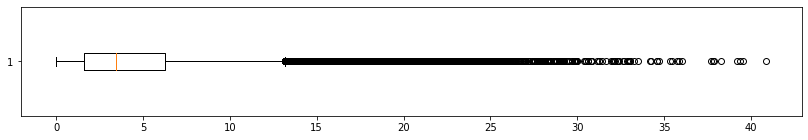

498-1268
Mean Absolute Error =  1.5742177273503632


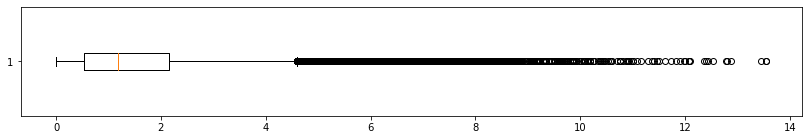

In [19]:
dict2data={} 
count = 0
for i,k in agg_by_cell:
    cell = i
    print(cell)
    
    serie_dati = k['nr_people'].values
    
    # split into samples
    X, y = split_sequence(serie_dati, n_steps_in, n_steps_out)
    
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    
    # train-validation-test
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)
    train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.3, random_state=1)
  
    # define model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
    model.add(MaxPooling1D(pool_size=2)) 
    model.add(Flatten())
    model.add(Dense(50, activation='relu')) 
    model.add(Dense(n_steps_out)) 
    model.compile(optimizer='adam', loss='mse')

    # fit model
    model.fit(train_X, train_y, epochs=100, verbose=0)
    
    
    # predict and compute error
    predicted = np.array([])

    for i in range(len(val_X)):
        x_input = val_X[i].reshape((1, n_steps_in, n_features))
        yhat = model.predict(x_input, verbose=0)
        predicted = np.append(predicted, yhat[0]) 

    #predicted = predicted.reshape(-1, 1)    
    expected = val_y   
    expected = np.reshape(expected, (expected.shape[0]*expected.shape[1]))
    
    # abs difference
    error = abs((expected - predicted))
    print('Mean Absolute Error = ', np.mean(error))
    
    # collect data 2 dictionary
    minimum = np.amin(error)   
    per75 = np.percentile(error, 75)
    per50 = np.percentile(error, 50)
    per25 = np.percentile(error, 25)
    maximum = np.amax(error)
    l5i = [minimum, per25, per50, per75, maximum]
    #l5i = ','.join(l5i)
    dict2data[cell] = l5i
    
    # plot data
    plt.figure(figsize = (14,2))
    plt.boxplot(error, vert= False);
    plt.show()
    
with open('error_data_4_CNN_MultistepForcast_25.csv', 'w') as f:
    for key, value in dict2data.items():
        f.write('%s:%s\n' % (key, value))    